# Třída svítivosti

V tomto dokumentu dojde k vytvoření neuronové sítě pro rozpoznávání třídy svítivosti hvězd na základě jejich absolutní magnitudy a barevného indexu B-V. K tomu je třeba importovat následující knihovny a moduly:

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

## Příprava dat

K naučení neuronové sítě bude použit dataset dostupný přes [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=V/137D/XHIP). Bylo vybráno pouze 579 hvězd reprezentujících všechny možné třídy svítivosti.

In [12]:
data = pd.read_csv("stars.csv")
data

,teff,mag,lum_class
0,3068,16.12,5
1,3042,16.60,5
2,2600,18.70,5
3,2800,16.65,5
4,1939,20.06,5
...,...,...,...
574,4700,1.62,3
575,4550,1.44,3
576,5000,1.65,3
577,4550,1.40,3


Z teploty `teff` nejdříve odvodíme barevný index B-V.

In [13]:
spect_classes = ["O", "B", "A", "F", "G", "K", "M", "L", "T"]
classes = ["0", "I", "II", "III", "IV", "V", "VI", "VII"]

data["bv"] = data["teff"].apply(lambda t: -3.684 * np.log10(t) + 14.551 if t < 9641 else 0.344 * np.log10(t)**2 - 3.402 * np.log10(t) + 8.037)

data

,teff,mag,lum_class,bv
0,3068,16.12,5,1.705425
1,3042,16.60,5,1.719041
2,2600,18.70,5,1.970238
3,2800,16.65,5,1.851670
4,1939,20.06,5,2.439563
...,...,...,...,...
574,4700,1.62,3,1.022991
575,4550,1.44,3,1.074886
576,5000,1.65,3,0.923995
577,4550,1.40,3,1.074886


Následně sestrojíme graf zobrazující tyto veličiny:

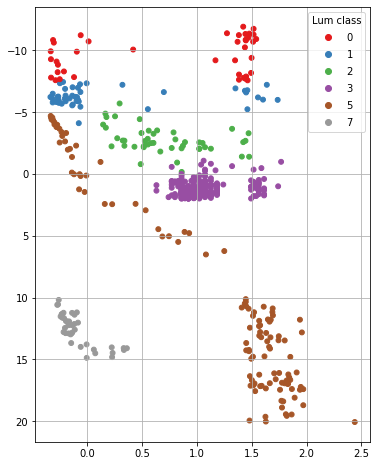

In [14]:
plt.rcParams["figure.figsize"] = (6,8)
plt.grid()
plt.gca().invert_yaxis()
sc = plt.scatter(data["bv"], data["mag"], c=data["lum_class"], cmap="Set1", s=24)

handles, labels = sc.legend_elements(prop="colors")
legend = plt.legend(handles, labels, title="Lum class")

Jednotlivé třídy svítivosti jsou zřetelně odděleny a jejich rozmístění odpovídá [Hertzsprungovu–Russellovu diagramu](https://cs.wikipedia.org/wiki/Hertzsprung%C5%AFv%E2%80%93Russell%C5%AFv_diagram).

## Sestrojení neuronové sítě

Nejdříve definujeme architekturu sítě.

In [15]:
nn = Sequential([
    Dense(32, input_shape=(2,), activation="relu"),
    Dense(len(classes), activation="softmax")
])

nn.compile(optimizer="rmsprop", loss="mse")
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


Následně rozdělíme námi připravená data na trénovací (80 %) a testovací (20 %).

In [17]:
data = data.sample(frac=1)  # Shuffle
data = data.reset_index(drop=True)

test_size = round(0.15 * data.shape[0])

x = data[["bv", "mag"]].to_numpy()
x_train, x_test = x[test_size:], x[:test_size]

y = np.zeros((data.shape[0], len(classes)))

for i, item in data.iterrows():
    #y[i,classes.index(item["lum_class"])] = 1
    y[i,int(item["lum_class"])] = 1
    
y_train, y_test = y[test_size:], y[:test_size]

Síť naučíme z trénovacích dat:

In [ ]:
stop = EarlyStopping(monitor="loss", patience=20)
nn.fit(x_train, y_train, epochs=1000, callbacks=[stop])

Nakonec otestujeme úspěšnost sítě.

In [19]:
result = nn.predict(x_test)
(result.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(result)

0.9770114942528736

Úspěšnost sítě se pohybuje mezi 95 % a 100 %, což je pro účely aplikace dostačující. Pro použití i mimo tento dokument vytvořenou a naučenou neuronovou síť uložíme do souboru.

In [20]:
nn.save("lum_class.h5")
#model = load_model("lum_class.h5")